This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window
from pathlib import Path

Currently, we don't have a way to link chips and planet IDs we are using so this is manual.

In [3]:
PLANET_ID = '20211003_161639_91_241d_3B_AnalyticMS_SR_8b'

In [4]:
planet_image_path = Path(f'local_chips/{PLANET_ID}.tif')
planet_image_path.exists()

True

# Load Chips

Want to crop image based on chip

In [5]:
df = gpd.read_file('chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [6]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(10003, 13622)

In [7]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-95.866875,33.03,3,3_40,2011-07-10,1,42,"POLYGON ((222530.752 3668526.777, 241571.451 3..."


It's a little weird because all Planet Imagery is in UTM and Chips are in Lon/Lat.

In [8]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

We are going to label things based on the chip index.

In [9]:
index = df_chip.random_id[0]
index

42

In [10]:
with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(6838, 6840, 8)

In [11]:
with rasterio.open(planet_image_path) as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

In [12]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

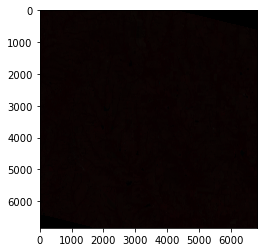

In [13]:
rgb = scale_img(image_c[..., [7, 5, 3]])
plt.imshow(rgb)

In [14]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.50s/it]


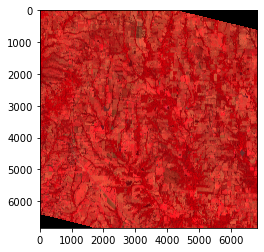

In [15]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [16]:
p = profile_cropped.copy()
p['count'] = 3
p['dtype'] = 'float32'
p['nodata'] = np.nan
with rasterio.open(f'cropped_to_chip_{index}.tif', 'w', **p) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

You could use the above to figure out some training data. We label it `training_data_{index}`, according to the chip ID.

# Segmentation

Going to use multiscale superpixels - see [this paper](https://www.mdpi.com/2072-4292/12/12/2048) and the references. I learned about them [here](https://link.springer.com/chapter/10.1007/978-94-017-7239-6_8).

Best discussion of felzenswalb algorithm (and parameters below) is by a fellow JPL team: https://ieeexplore.ieee.org/document/5593215

In [17]:
def get_segmentation(image, min_size):
    mask = np.isnan(image[..., 0])
    image_seg = image.copy()
    # So that np.nans don't give us problems
    image_seg[mask, :] = -10_000
    segments_fz = felzenszwalb(image_seg,
                               # may want to play with this
                               scale=10, 
                               # normally gaussian filter is applied - can experiment
                               sigma=0.25,
                               # minimum size of segments
                               min_size=min_size
                              )
    return segments_fz

We are going to use the RGB image from above.

In [18]:
get_segmentation_partial = lambda min_size: get_segmentation(rgb, min_size)
segmentations = list(map(get_segmentation_partial, tqdm([10, 25, 50])))

100%|██████████████████████████████████████| 3/3 [07:55<00:00, 158.41s/it]


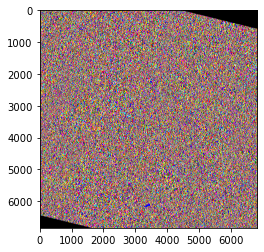

In [19]:
X = segmentations[0].copy()
X[mask] = 0
superpixel_labels_viz = label2rgb(X, bg_label=0)
plt.imshow(superpixel_labels_viz)

Below would be used to save the segments to a vector file. It takes some time and the segments can be approximately ~1 GB.

In [20]:
segments_fz = segmentations[1]

In [21]:
%%time

# features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
#                                              profile['transform'], 
#                                              label_name='label')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [22]:
%%time

# df_segments = gpd.GeoDataFrame.from_features(features)
# df_segments.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [23]:
%%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


# Generate Features

In [24]:
rgb.shape

(6838, 6840, 3)

In [25]:
pixel_features = rgb.reshape((-1, rgb.shape[-1]))

In [26]:
multi_superpixel_features_mean = [get_superpixel_means_as_features(seg, rgb) for seg in tqdm(segmentations)]

100%|███████████████████████████████████████| 3/3 [00:18<00:00,  6.07s/it]


In [27]:
multi_superpixel_features_mean[0].shape

(1043496, 3)

In [28]:
multi_superpixel_features_std = [get_superpixel_stds_as_features(seg, rgb) for seg in tqdm(segmentations)]

  0%|                                               | 0/3 [00:00<?, ?it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_calval/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts
100%|███████████████████████████████████████| 3/3 [00:22<00:00,  7.48s/it]


In [29]:
multi_superpixel_means = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_mean)]
multi_superpixel_stds = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_std)]

100%|███████████████████████████████████████| 3/3 [00:24<00:00,  8.28s/it]


In [30]:
scale_ind = 0
img_super = multi_superpixel_means[scale_ind]
p['count'] = 3

with rasterio.open(f'superpixel_means_{scale_ind}_{index}.tif', 'w', **p) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [31]:
scale_ind = 0
img_super = multi_superpixel_stds[scale_ind]
p['count'] = 3

with rasterio.open(f'superpixel_stds_{scale_ind}_{index}.tif', 'w', **p) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [32]:
superpixel_means_pixel_f = [superpixel_means.reshape((-1, rgb.shape[-1])) 
                            for superpixel_means in multi_superpixel_means]
superpixel_stds_pixel_f = [superpixel_stds.reshape((-1, rgb.shape[-1])) 
                            for superpixel_stds in multi_superpixel_stds]

In [33]:
all_features = np.hstack([pixel_features] +  superpixel_means_pixel_f + superpixel_stds_pixel_f)
all_features.shape

(46771920, 21)

# Load Training data

I made this training data with:

```
1 - no water
2 - water
```

Because then we can assign 0 as nodata value in the final classes.

<AxesSubplot:>

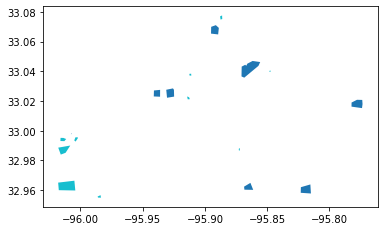

In [34]:
df = gpd.read_file(f'training_data_42.geojson')
df = df[~df.geometry.isna()].reset_index(drop=True)
df.plot(column='label_name')

In [35]:
# df.to_file('training_data_42.geojson', driver='GeoJSON')

In [36]:
labels = rasterize_shapes_to_array(df.to_crs(profile_cropped['crs']).geometry, 
                                   df.label, 
                                   profile_cropped, 
                                   all_touched=False)

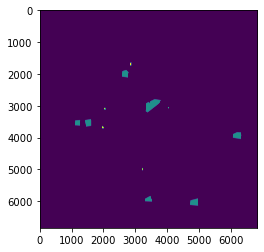

In [37]:
plt.imshow(labels)

In [38]:
labels_f = labels.reshape((-1, 1)).ravel()

f_mask = ~(labels_f == 0).ravel()

In [39]:
X_labeled = all_features[f_mask]
y_labeled = labels_f[f_mask]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.1, 
                                                    random_state=0)

In [41]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=8)

In [42]:
%%time

rf.fit(X_train, 
       y_train)


CPU times: user 1min 50s, sys: 6.52 s, total: 1min 56s
Wall time: 24.9 s


RandomForestClassifier(n_estimators=500, n_jobs=8, oob_score=True,
                       random_state=0)

In [43]:
%%time

y_pred = rf.predict(X_test)


CPU times: user 697 ms, sys: 128 ms, total: 825 ms
Wall time: 231 ms


In [44]:
class_dict = {1: 'not_water', 
              2: 'water'}

In [45]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

This gives us how well we did on the labeled test data. Random forests will do pretty well on the labeled data since the labeled data is continugous and the superpixels aggregations will likely be shared across pixels.

In [46]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted,not_water,water
True,,
not_water,31683,0
water,0,1133


In [47]:
all_mask_f = (mask.reshape((-1,)))

X_all = all_features[~all_mask_f, 
                     ...]

In [48]:
%%time

y_all = rf.predict(X_all)

CPU times: user 17min 18s, sys: 4min 16s, total: 21min 35s
Wall time: 3min 17s


In [49]:
y_arr = np.zeros(mask.shape)

y_arr[~mask] = y_all
y_arr[mask] = 0

In [50]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
with rasterio.open(f'class_out_{index}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

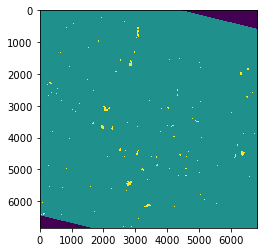

In [51]:
plt.imshow(y_arr, interpolation='none')

# Feature Importances

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

In [52]:
rf.feature_importances_

array([0.06822466, 0.00175802, 0.00032476, 0.13639425, 0.0021276 ,
       0.00073764, 0.21566308, 0.00216347, 0.00125039, 0.22274632,
       0.00305851, 0.0006657 , 0.09869575, 0.0018323 , 0.00194138,
       0.07640898, 0.0050728 , 0.00744506, 0.13360528, 0.00885232,
       0.01103175])